This Notebook is created to analyse the cloud data.
-
This is a colection of functions that help to differentiate between valid and false data.
-

ql_vertmax_20160530.nc
ql_vertmax_20160818.nc
ql_vertmax_20160610.nc
ql_vertmax_20160819.nc
ql_vertmax_20150606.nc
ql_vertmax_20160611.nc timestep 7*
ql_vertmax_20160830.nc bad start (seems caused by the simulation)
ql_vertmax_20150609.nc seems broken
ql_vertmax_20160619.nc seems broken
ql_vertmax_20170509.nc timestep 10*,11,17
ql_vertmax_20150627.nc timestep 6*
ql_vertmax_20160625.nc timestep 9*
ql_vertmax_20170605.nc timestep 7*,8,9,...(broken)
ql_vertmax_20150801.nc
ql_vertmax_20160719.nc
ql_vertmax_20160720.nc seems broken
ql_vertmax_20160518.nc seems broken

In [48]:
import numpy as np
from importlib import reload
import pandas as pd
import slopes_and_binning
from slopes_and_binning import *
reload(slopes_and_binning)
import cloud_and_plumes_slopes
from cloud_and_plumes_slopes import *
reload(cloud_and_plumes_slopes)
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from random import random
import matplotlib
import sys

In [50]:
cloud_file = './data/ql_vertmax_20160719.nc'
cloud_data = Dataset(cloud_file)

Let's have a look at the resulting slopes using the 3 different distribution methods
-

n_clouds[ 9 ]: 14
n_clouds[ 10 ]: 155
n_clouds[ 11 ]: 408
min at pos 23
max at pos 12
CPU times: user 500 ms, sys: 52.3 ms, total: 553 ms
Wall time: 551 ms


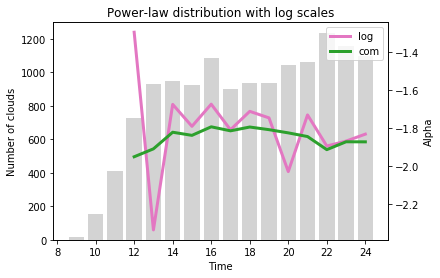

In [97]:
%%time
import numpy as np
from importlib import reload
import slopes_and_binning
from slopes_and_binning import *
reload(slopes_and_binning)
import cloud_and_plumes_slopes
from cloud_and_plumes_slopes import *
reload(cloud_and_plumes_slopes)
import matplotlib.pyplot as plt

thresh = 1e-6
min_pixel = 4
bin_n = 75
bin_min = 25
bin_max = 500

n_clouds = []
time = np.arange(len(cloud_data.variables['time'][:]))
data = cloud_data.variables['ql'][time,:,:]
time, n_clouds, slope_lin, slope_log, slope_com = plot_cloud_alpha(data,time,bin_n,bin_min,bin_max,thresh,min_pixel,n_cloud_min=500)

slope_var = []

for i in range(len(slope_log)):
    if np.isnan(slope_log[i]):
        slope_var.append(slope_log[i])
    else:
        slope_var.append(np.abs(slope_log[i]-slope_com[i]))
        
print ('min at pos',np.nanargmin(slope_var)+len(cloud_data.variables['time'][:])-len(time))
print ('max at pos',np.nanargmax(slope_var)+len(cloud_data.variables['time'][:])-len(time))

axes = plt

axes.bar(time, n_clouds, color='lightgrey')
axes.xlabel('Time')
axes.ylabel('Number of clouds')  # we already handled the x-label with ax1
#axes[0].text(np.max(x_bins_lin), np.max(y), r'$\alpha = %f$' % m1, horizontalalignment='right',verticalalignment='top')
axes.title('Power-law distribution with log scales')
#axes[0].axvspan(x_min_shade, x_max_shade, color='lightgray', alpha=0.5, lw=0)

axes2 = axes.twinx()

axes2.set_ylabel('Alpha')
#axes2.plot(time, slope_lin, linewidth=3, color='tab:red', label='lin')
axes2.plot(time, slope_log, linewidth=3, color='tab:pink', label='log')
axes2.plot(time, slope_com, linewidth=3, color='tab:green', label='com')

plt.legend()

Let's check out the timestep where the com and log slopes are furthest apart
-
[notice] cell above needs to be executed first, to obtain slopes_log and slope_com

min: 0.0035578276932670683 at pos 23
max: 0.6569557148105227 at pos 12
slopes: -1.294157328340976 -1.9511130431514987
timestep: 12 [ 3 ]
CPU times: user 594 ms, sys: 46.1 ms, total: 640 ms
Wall time: 802 ms


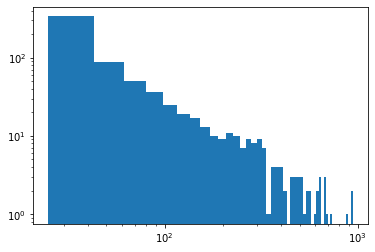

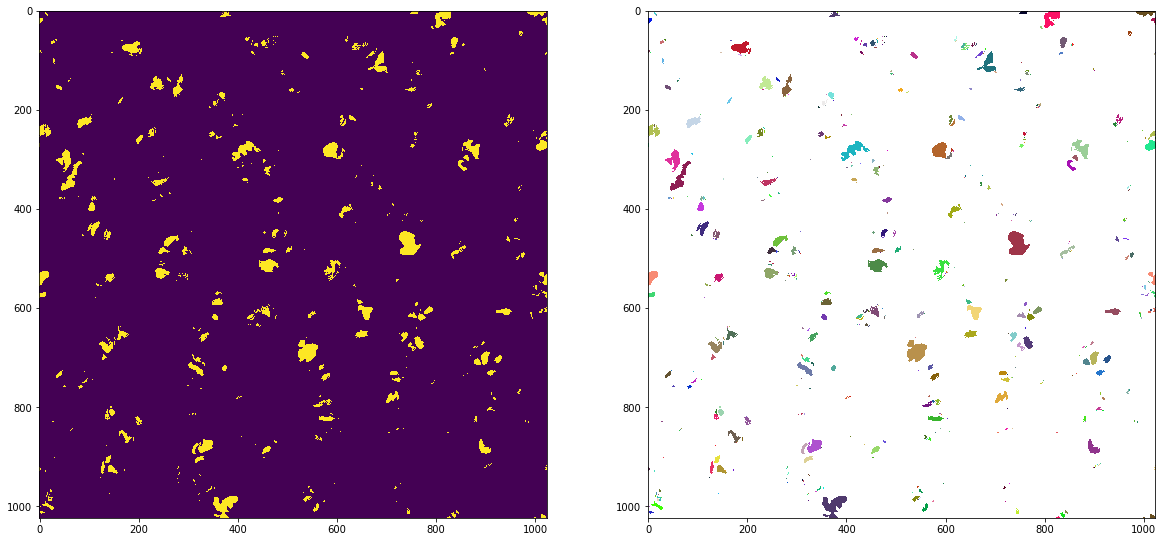

In [52]:
%%time
import numpy as np
from importlib import reload
import slopes_and_binning
from slopes_and_binning import *
reload(slopes_and_binning)
import cloud_and_plumes_slopes
from cloud_and_plumes_slopes import *
reload(cloud_and_plumes_slopes)
import matplotlib.pyplot as plt
from random import random

#buffer_size given as a percentage of the full domain's length
buffer_size = .5

colors = [(0.5,0.5,0.5)] + [(random(),random(),random()) for i in range(1000)]
random_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('random_cmap', colors, N=1000)

absolute = []
for i in range(len(slope_log)):
    if np.isnan(slope_log[i]):
        absolute.append(slope_log[i])
    else:
        absolute.append(np.abs(slope_log[i]-slope_com[i]))
        
timestep = np.nanargmax(absolute)+len(cloud_data.variables['time'][:])-len(time)

print ('min:',np.nanmin(absolute),'at pos',np.nanargmin(absolute)+len(cloud_data.variables['time'][:])-len(time))
print ('max:',np.nanmax(absolute),'at pos',np.nanargmax(absolute)+len(cloud_data.variables['time'][:])-len(time))

print ('slopes:',slope_log[timestep-len(cloud_data.variables['time'][:])+len(time)], slope_com[timestep-len(cloud_data.variables['time'][:])+len(time)])
print ('timestep:',timestep,'[',timestep-len(cloud_data.variables['time'][:])+len(time),']')

# marks everything above ref_min as a cloud
cloud_2D_mask = np.zeros_like(cloud_data.variables['ql'][timestep,:,:])
cloud_2D_mask[cloud_data.variables['ql'][timestep,:,:] > thresh] = 1

# calculates how many clouds exist in cloud_2D_mask, returns total number of clouds
labeled_clouds, A_buf, n_buffer, cloud_center, cloud_pixels = cluster_2D(cloud_2D_mask,buffer_size)

#Grosse jeder wolken
label, cl_pixels = np.unique(labeled_clouds.ravel(),return_counts=True)
cl_size = np.sqrt(cl_pixels*25.*25.)

plt.hist(cl_size[1:],bins=50)
plt.yscale('log')
plt.xscale('log')

masked_clouds = np.ma.masked_where(labeled_clouds<1,labeled_clouds)
fig,ax = plt.subplots(1,2,figsize=(20,10))
im1  =ax[0].imshow(cloud_2D_mask)
im1  =ax[1].imshow(masked_clouds,cmap=random_cmap)

Now where we've seen a snapshot of the cloud field, let's investigate the slope calculation
-
The areas covered in light grey have been filtered and did not influence the slope calculation

[notice] timestep should have been selected by the cell abow. Otherwise timestep needs to be specified.

number of clouds: 728
-1.3979912394099563 -2.004441673600462 -1.9511130431514987
timestep 12
CPU times: user 215 ms, sys: 28 ms, total: 243 ms
Wall time: 162 ms


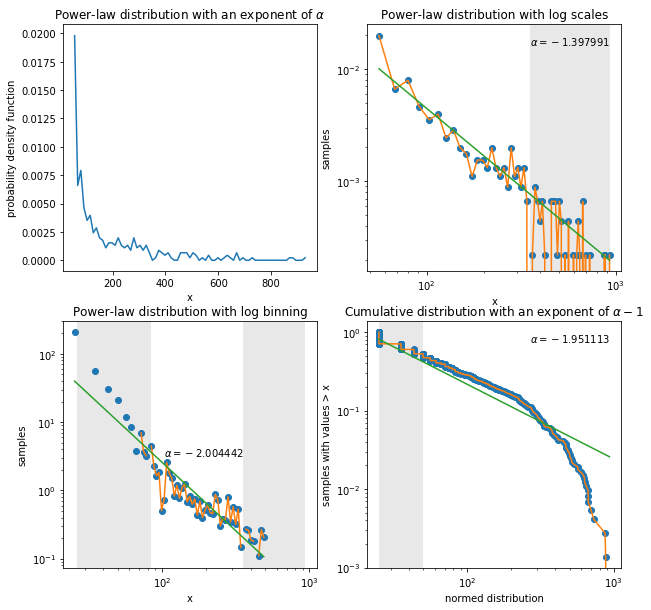

In [88]:
%%time
import numpy as np
from importlib import reload
import slopes_and_binning
from slopes_and_binning import *
reload(slopes_and_binning)
import cloud_and_plumes_slopes
from cloud_and_plumes_slopes import *
reload(cloud_and_plumes_slopes)
import matplotlib.pyplot as plt

#timestep = 12
thresh = 1e-6
min_pixel = 4
bin_n = 75
bin_min = 25
bin_max = 500
show_plt = True

fig,m1,m2,m3 = cloud_size_dist('ql',timestep,bin_n,bin_min,bin_max,thresh,cloud_data,min_pixel,show_plt)
#plt.savefig("ql_vertmax_20160818_timestep_9.pdf")
print(m1,m2,m3)
print('timestep',timestep)

The next test uses slope calculation described in Neggers et. al, 2018
-
The slopes are calculated for the whole timeseries

If log_binning = False is selected the algorythm uses linear bins

[notice] timestep should have been selected by the cell abow. Otherwise timestep needs to be specified.

min cloud area: 75.0 
max cloud area: 1148.9125293076058
timestep: 10
Number of Subdomains: 8
Number of Subdomains: 40
Number of Subdomains: 176
Number of Subdomains: 736
Number of Subdomains: 3008


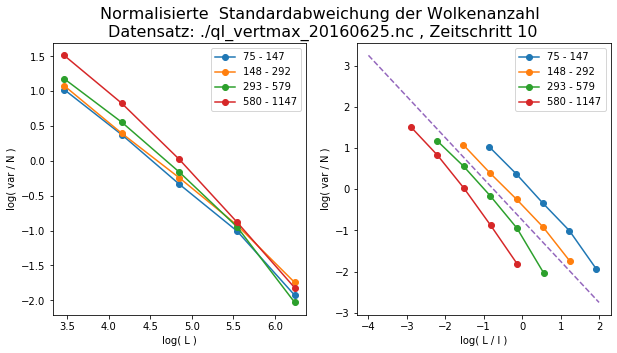

CPU times: user 1.69 s, sys: 31.8 ms, total: 1.72 s
Wall time: 1.72 s


In [21]:
%%time
import numpy as np
from importlib import reload
import slopes_and_binning
from slopes_and_binning import *
reload(slopes_and_binning)
import cloud_and_plumes_slopes
from cloud_and_plumes_slopes import *
reload(cloud_and_plumes_slopes)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#timestep = 10
subdomains = [2,4,8,16,32]
n_bins = 4
log_binning = True
inbetween_subs = True
min_pixel = 9

l2D = cloud_data.variables['ql'][timestep,:,:]
l2D_bi = np.zeros_like(l2D).astype(int)
l2D_bi[l2D>1e-6]=1

labeled_clouds, l2D_bi_buf, n_buffer, cloud_center, cloud_pixels = cluster_2D(l2D_bi,buffer_size)

cloud_size = np.sqrt(np.asarray(cloud_pixels))*25.
cloud_center = np.asarray(cloud_center)

new_arr = np.zeros_like(l2D_bi).astype(float)
new_arr[cloud_center[:,0],cloud_center[:,1]] = cloud_size

var = []
N_mean =  []
L = []

cloud_area_min = np.sqrt(min_pixel)*25.
cloud_area_max = np.max(cloud_size)
print ('min cloud area:',cloud_area_min,'\nmax cloud area:',cloud_area_max)
print ('timestep:',timestep)

for n_x_slices in subdomains:
    n_y_slices = n_x_slices
    x_split = int(l2D_bi.shape[0] / n_x_slices)
    y_split = int(l2D_bi.shape[0] / n_y_slices)
    
    dist = []
    var_sub = []
    N_mean_sub = []
    
    L.append(len(new_arr)/n_x_slices)
    for y in range(n_y_slices):
        for x in range(n_x_slices):
            tmp_sub = new_arr[y*y_split:(y+1)*y_split,x*x_split:(x+1)*x_split]
            tmp_cl_size = tmp_sub[tmp_sub>np.sqrt(min_pixel)*25.]
            if (log_binning):
                n_cl_per_bin, l = np.histogram(tmp_cl_size, bins=np.logspace(np.log10(cloud_area_min),np.log10(cloud_area_max), n_bins+1),range=(cloud_area_min, cloud_area_max))
            else:
                n_cl_per_bin, l = np.histogram(tmp_cl_size, bins=n_bins,range=(cloud_area_min, cloud_area_max))
            dist.append(n_cl_per_bin)
            
    if inbetween_subs:
                for y in range(n_y_slices):
                    for x in range(n_x_slices-1):
                        tmp_sub = new_arr[y*y_split:(y+1)*y_split,int((x+.5)*x_split):int((x+1.5)*x_split)]
                        tmp_cl_size = tmp_sub[tmp_sub>np.sqrt(min_pixel)*25.]
                        if log_binning:
                            n_cl_per_bin, l = np.histogram(tmp_cl_size, bins=np.logspace(np.log10(cloud_area_min),np.log10(cloud_area_max), n_bins+1),range=(cloud_area_min, cloud_area_max))
                        else:
                            n_cl_per_bin, l = np.histogram(tmp_cl_size, bins=n_bins,range=(cloud_area_min, cloud_area_max))
                        dist.append(n_cl_per_bin)

                for y in range(n_y_slices-1):
                    for x in range(n_x_slices):
                        tmp_sub = new_arr[int((y+.5)*y_split):int((y+1.5)*y_split),x*x_split:(x+1)*x_split]
                        tmp_cl_size = tmp_sub[tmp_sub>np.sqrt(min_pixel)*25.]
                        if log_binning:
                            n_cl_per_bin, l = np.histogram(tmp_cl_size, bins=np.logspace(np.log10(cloud_area_min),np.log10(cloud_area_max), n_bins+1),range=(cloud_area_min, cloud_area_max))
                        else:
                            n_cl_per_bin, l = np.histogram(tmp_cl_size, bins=n_bins,range=(cloud_area_min, cloud_area_max))
                        dist.append(n_cl_per_bin)

    dist = np.asarray(dist)
    print('Number of Subdomains:',len(dist[:,0]))
    
    for i in range(n_bins):
        N_mean_sub.append(np.mean(dist[:,i]))
        var_sub.append(np.sqrt(np.sum((dist[:,i]-N_mean_sub[i])**2)/len(dist[:,0])))

    var.append(var_sub)
    N_mean.append(N_mean_sub)
    
N_mean = np.asarray(N_mean)
var = np.asarray(var)

fig,ax = plt.subplots(1,2,figsize=(10,5))
y_axis = np.log(var/N_mean)

slope = []
intercept = []
for i in range(n_bins):
    x_axis = np.log(L/l[i])
    
    im1 = ax[0].plot(np.log(L),y_axis[:,i], '-o', label='%i - %i'%(int(l[i]),int(l[i+1])-1))
    im2 = ax[1].plot(x_axis,y_axis[:,i], '-o', label='%i - %i'%(int(l[i]),int(l[i+1])-1))
    
im1 = ax[1].plot([-4,2],np.polyval([-1,-.75],[-4,2]),'--')

fig.suptitle('Normalisierte  Standardabweichung der Wolkenanzahl \nDatensatz: %s , Zeitschritt %i' % (cloud_file,timestep), fontsize=16)

ax[0].legend(loc='best')
ax[0].set_xlabel('log( L )')
ax[0].set_ylabel('log( var / N )')

ax[1].legend(loc='best')
ax[1].set_xlabel('log( L / l )')
ax[1].set_ylabel('log( var / N )')

plt.show()

timestep 0 is invalid.
timestep 1 is invalid.
timestep 2 is invalid.
timestep 3 is invalid.
timestep 4 is invalid.
timestep 5 is invalid.


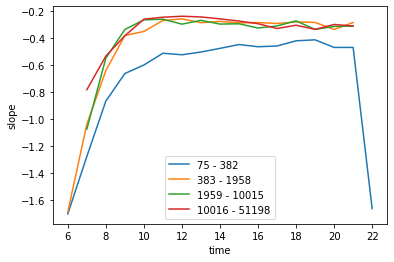

CPU times: user 25.7 s, sys: 276 ms, total: 26 s
Wall time: 26 s


In [16]:
%%time
import numpy as np
from importlib import reload
import slopes_and_binning
from slopes_and_binning import *
reload(slopes_and_binning)
import cloud_and_plumes_slopes
from cloud_and_plumes_slopes import *
reload(cloud_and_plumes_slopes)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

subdomains = [2,4,8,16,32]
n_bins = 4
log_binning = True
inbetween_subs = True
min_pixel = 9

time_len = len(cloud_data.variables['ql'][:,0,0])
f = np.zeros((n_bins,2,time_len))

for timestep in range(time_len):

    l2D = cloud_data.variables['ql'][timestep,:,:]
    l2D_bi = np.zeros_like(l2D).astype(int)
    l2D_bi[l2D>1e-6]=1
    
    if (len(l2D_bi[l2D_bi==1])>25):
        labeled_clouds, l2D_bi_buf, n_buffer, cloud_center, cloud_pixels = cluster_2D(l2D_bi,buffer_size)

        cloud_size = np.sqrt(np.asarray(cloud_pixels))*25.
        cloud_center = np.asarray(cloud_center)

        new_arr = np.zeros_like(l2D_bi).astype(float)
        new_arr[cloud_center[:,0],cloud_center[:,1]] = cloud_size

        cloud_area_min = np.sqrt(min_pixel)*25.
        cloud_area_max = np.max(cloud_size)
        #print ('min cloud area:',cloud_area_min,'\nmax cloud area:',cloud_area_max)

        for n_x_slices in subdomains:
            n_y_slices = n_x_slices
            x_split = int(l2D_bi.shape[0] / n_x_slices)
            y_split = int(l2D_bi.shape[0] / n_y_slices)

            var = []
            N_mean =  []
            L = []

            dist = []
            var_sub = []
            N_mean_sub = []

            L.append(len(new_arr)/n_x_slices)
            for y in range(n_y_slices):
                for x in range(n_x_slices):
                    tmp_sub = new_arr[y*y_split:(y+1)*y_split,x*x_split:(x+1)*x_split]
                    tmp_cl_size = tmp_sub[tmp_sub>np.sqrt(min_pixel)*25.]
                    if log_binning:
                        n_cl_per_bin, l = np.histogram(tmp_cl_size, bins=np.logspace(np.log10(cloud_area_min),np.log10(cloud_area_max), n_bins+1),range=(cloud_area_min, cloud_area_max))
                    else:
                        n_cl_per_bin, l = np.histogram(tmp_cl_size, bins=n_bins,range=(cloud_area_min, cloud_area_max))
                    dist.append(n_cl_per_bin)
            if inbetween_subs:
                for y in range(n_y_slices):
                    for x in range(n_x_slices-1):
                        tmp_sub = new_arr[y*y_split:(y+1)*y_split,int((x+.5)*x_split):int((x+1.5)*x_split)]
                        tmp_cl_size = tmp_sub[tmp_sub>np.sqrt(min_pixel)*25.]
                        if log_binning:
                            n_cl_per_bin, l = np.histogram(tmp_cl_size, bins=np.logspace(np.log10(cloud_area_min),np.log10(cloud_area_max), n_bins+1),range=(cloud_area_min, cloud_area_max))
                        else:
                            n_cl_per_bin, l = np.histogram(tmp_cl_size, bins=n_bins,range=(cloud_area_min, cloud_area_max))
                        dist.append(n_cl_per_bin)

                for y in range(n_y_slices-1):
                    for x in range(n_x_slices):
                        tmp_sub = new_arr[int((y+.5)*y_split):int((y+1.5)*y_split),x*x_split:(x+1)*x_split]
                        tmp_cl_size = tmp_sub[tmp_sub>np.sqrt(min_pixel)*25.]
                        if log_binning:
                            n_cl_per_bin, l = np.histogram(tmp_cl_size, bins=np.logspace(np.log10(cloud_area_min),np.log10(cloud_area_max), n_bins+1),range=(cloud_area_min, cloud_area_max))
                        else:
                            n_cl_per_bin, l = np.histogram(tmp_cl_size, bins=n_bins,range=(cloud_area_min, cloud_area_max))
                        dist.append(n_cl_per_bin)

            dist = np.asarray(dist)
            for i in range(n_bins):
                N_mean_sub.append(np.mean(dist[:,i]))
                var_sub.append(np.sqrt(np.sum((dist[:,i]-N_mean_sub[i])**2)/len(dist[:,0])))

            var.append(var_sub)
            N_mean.append(N_mean_sub)
    
        N_mean = np.asarray(N_mean)
        var = np.asarray(var)
        
        y_axis = np.log(var/N_mean)
        slope = []
        intercept = []
        for i in range(n_bins):
            x_axis = np.log(L/l[i])
            m, b = np.polyfit(x_axis, y_axis[:,i], 1)
            slope.append(m)
            intercept.append(b)
        #print(slope)
        f[:,0,timestep] = slope
        f[:,1,timestep] = intercept
        #print(timestep,'f:',f[:,:,timestep])
    else:
        f[:,:,timestep] = np.nan
        print('timestep',timestep,'is invalid.')

for i in range(len(f[:,0,0])):
    plt.plot(f[i,0,:],'-',label='%i - %i'%(int(l[i]),int(l[i+1])-1))
    
plt.legend()
plt.xlabel('time')
plt.ylabel('slope')
plt.show()

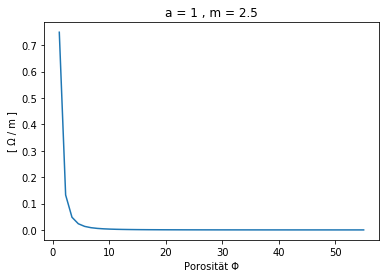

In [29]:
a = 1
m = 2.5
poro = np.linspace(0,55)
rho = a*(poro**(-m))
plt.plot(poro,rho)
plt.xlabel('Porosität Φ')
plt.ylabel('[ Ω / m ]')
plt.title('a = 1 , m = 2.5')
#plt.savefig('porosität_d.png')

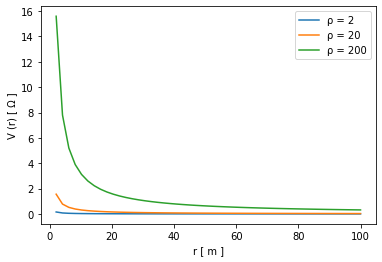

In [47]:
rho = [2,20,200]
r = np.linspace(0,100)
for i in rho:
    v = i/(2*np.pi*r)
    plt.plot(r,v,label='ρ = %i' %(i))
plt.xlabel('r [ m ]')
plt.ylabel('V (r) [ Ω ]')
#plt.title('Rho = 200 Ωm')
plt.legend(loc='best')
#plt.savefig('Potential.png')

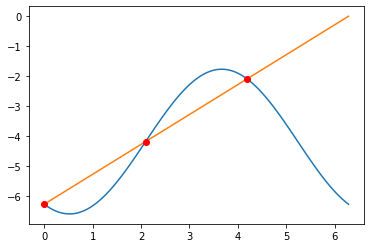

In [46]:
x = np.linspace(0,2*np.pi,100)
f = x - 2*np.pi
psi = -(4/3)*np.pi-(2/3)*np.pi*np.cos(x)-(2*np.sqrt(3)/9)*np.pi*np.sin(x)
plt.plot(x,psi)
plt.plot(x,f)
plt.plot(0,-2*np.pi,'o',color='red')
plt.plot(2*np.pi/3,-4*np.pi/3,'o',color='red')
plt.plot(4*np.pi/3,-2*np.pi/3,'o',color='red')

In [83]:
y = [1,2,3,4,np.nan,6]
x = [1,2,3,4,5,6]
m, b = np.polyfit(x,y,1)
print(m)
y2 = m*x+b
plt.plot(x,y)

nan


TypeError: can't multiply sequence by non-int of type 'numpy.float64'